# 🧠 Task 2.1 – Bayesian Change Point Modeling
Detecting structural breaks in Brent oil price returns using PyMC v4.
Includes preprocessing step from raw BrentOilPrices.csv.

In [1]:
!pip install numpy<2.0 pymc==5.10.4 arviz

/bin/bash: line 1: 2.0: No such file or directory


In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## 📂 Upload `BrentOilPrices.csv` and `event_data.csv`

In [3]:
uploaded = files.upload()

Saving BrentOilPrices.csv to BrentOilPrices.csv
Saving event_data.csv to event_data.csv


## 🧹 Preprocess BrentOilPrices.csv to generate log returns

In [4]:
df = pd.read_csv('BrentOilPrices.csv', dtype={'Date': 'string'})
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
df = df.sort_values('Date')
df['log_return'] = np.log(df['Price']) - np.log(df['Price'].shift(1))
df = df.dropna().reset_index(drop=True)
df.to_csv('brent_prices_processed.csv', index=False)
df.head()

,Date,Price,log_return
0,1987-05-21,18.45,-0.009709
1,1987-05-22,18.55,0.005405
2,1987-05-25,18.60,0.002692
3,1987-05-26,18.63,0.001612
4,1987-05-27,18.60,-0.001612


## 📊 Load Processed Data and Plot Log Returns

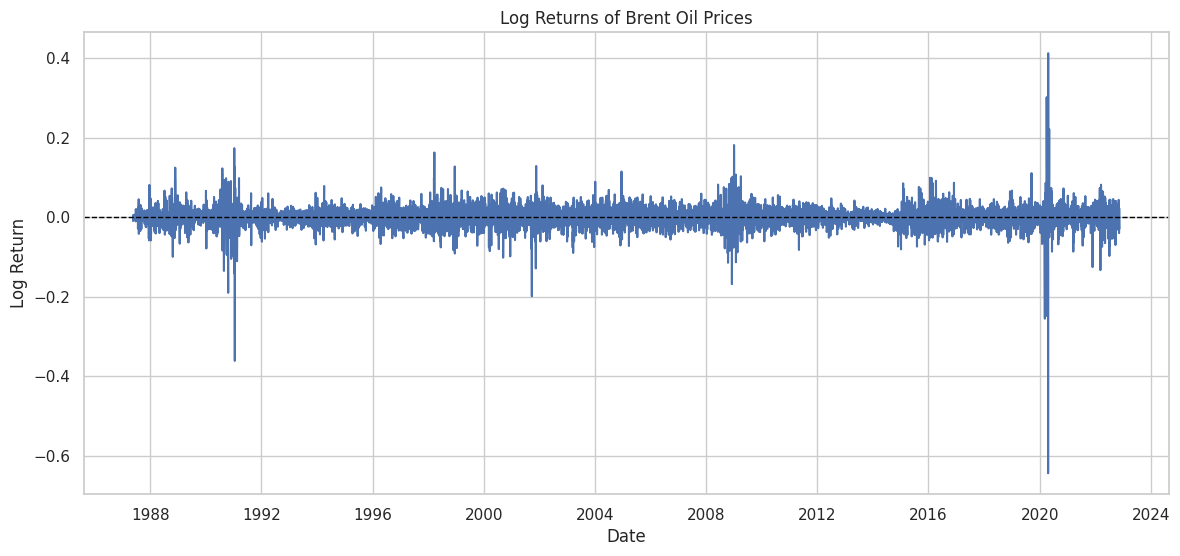

In [5]:
df = pd.read_csv('brent_prices_processed.csv', parse_dates=['Date'])
plt.plot(df['Date'], df['log_return'])
plt.title('Log Returns of Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

## 📈 Build Bayesian Change Point Model

In [6]:
returns = df['log_return'].values
n = len(returns)
idx = np.arange(n)

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)
    mu1 = pm.Normal('mu1', mu=np.mean(returns), sigma=np.std(returns))
    mu2 = pm.Normal('mu2', mu=np.mean(returns), sigma=np.std(returns))
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.switch(tau >= idx, mu1, mu2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)
    trace = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=42)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## 📊 Analyze Posterior Distributions and Extract Change Point

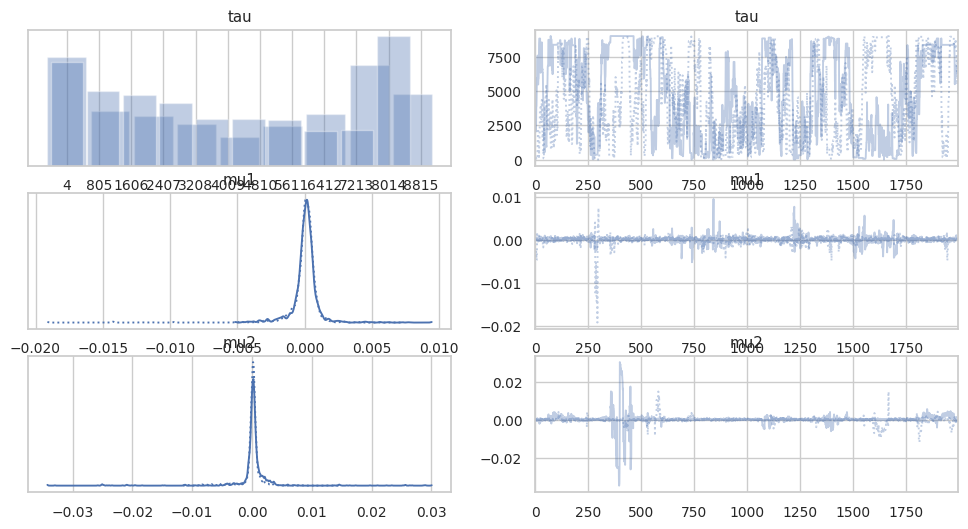

📅 Most likely change point date: 2004-04-13


In [7]:
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2'])
plt.show()

tau_median = int(np.median(trace.posterior['tau'].values.flatten()))
change_date = df.loc[tau_median, 'Date']
print(f"📅 Most likely change point date: {change_date.date()}")

## 🗓️ Match Detected Change Point with Known Events

In [10]:
events = pd.read_csv('event_data.csv', parse_dates=['Start Date'])
nearby_events = events[(events['Start Date'] >= change_date - pd.Timedelta(days=30)) &
                       (events['Start Date'] <= change_date + pd.Timedelta(days=30))]
print("📰 Events within ±30 days of detected change point:")
nearby_events

📰 Events within ±30 days of detected change point:


,Event Name,Start Date,Description


/tmp/ipython-input-2652735060.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('BrentOilPrices.csv', parse_dates=['Date'])


📊 Quantitative Summary:
→ Mean Log Return Before 2004-04-13: 0.000144
→ Mean Log Return After  2004-04-13: 0.000212
→ Absolute Change: 0.000068
→ Percentage Change: 47.35%


/tmp/ipython-input-2652735060.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(before_cp, shade=True, label='Before Change Point')
/tmp/ipython-input-2652735060.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(after_cp, shade=True, label='After Change Point')


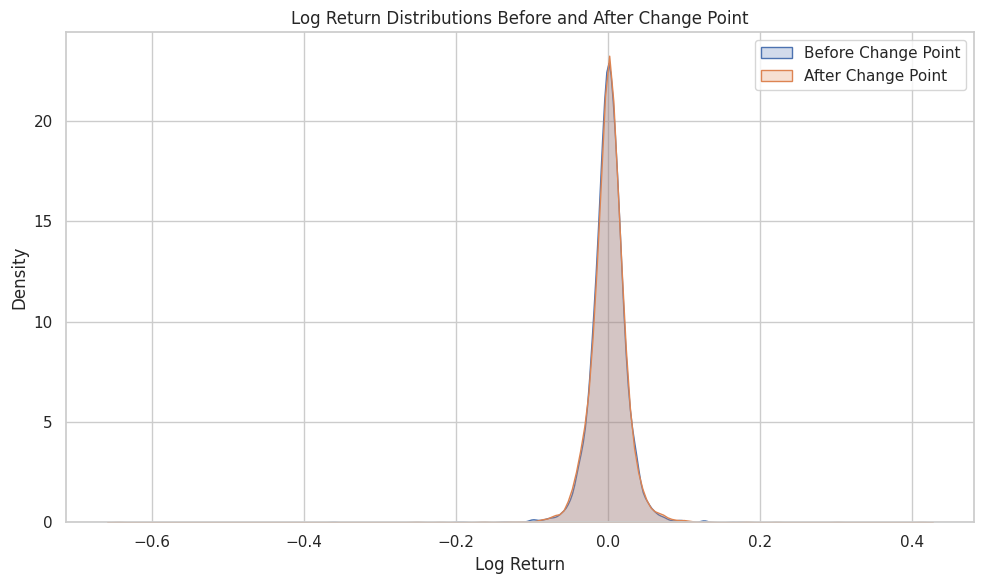

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('BrentOilPrices.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df['LogReturn'] = df['Price'].apply(lambda x: pd.NA if x <= 0 else x).apply(np.log).diff()

# Define change point date (replace this with your model output if different)
change_point_date = pd.to_datetime("2004-04-13")

# Segment the data
before_cp = df[df['Date'] < change_point_date]['LogReturn'].dropna()
after_cp = df[df['Date'] >= change_point_date]['LogReturn'].dropna()

# Compute means
mean_before = before_cp.mean()
mean_after = after_cp.mean()
diff = mean_after - mean_before
pct_change = (diff / abs(mean_before)) * 100

# Print summary
print("📊 Quantitative Summary:")
print(f"→ Mean Log Return Before 2004-04-13: {mean_before:.6f}")
print(f"→ Mean Log Return After  2004-04-13: {mean_after:.6f}")
print(f"→ Absolute Change: {diff:.6f}")
print(f"→ Percentage Change: {pct_change:.2f}%")

# Plot distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(before_cp, shade=True, label='Before Change Point')
sns.kdeplot(after_cp, shade=True, label='After Change Point')
plt.title("Log Return Distributions Before and After Change Point")
plt.xlabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Load and filter event data
events_df = pd.read_csv("event_data.csv", parse_dates=["Start Date"])
change_date = pd.to_datetime("2004-04-13")  # Replace with detected tau date if dynamically extracted

# Filter events ±30 days from change point
nearby_events = events_df[
    (events_df["Start Date"] >= change_date - pd.Timedelta(days=30)) &
    (events_df["Start Date"] <= change_date + pd.Timedelta(days=30))
]

# Display nearby events
print("📰 Events ±30 Days of Detected Change Point:\n")
if nearby_events.empty:
    print("⚠️ No major events recorded near the detected change point.")
else:
    display(nearby_events[["Event Name", "Start Date", "Description"]])


📰 Events ±30 Days of Detected Change Point:

⚠️ No major events recorded near the detected change point.
